In [1]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl
import wandb

from src import *

In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the growing CA part
old_CA = NeuralCA(device=device)
old_CA.load("Pretrained_models/firework_growing.pt")

for param in old_CA.parameters():
   param.requires_grad = False

Successfully loaded model!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


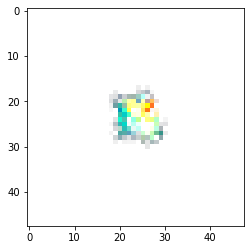

In [5]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 1, old_CA, iter_func=ExponentialSampler(max=50))
pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

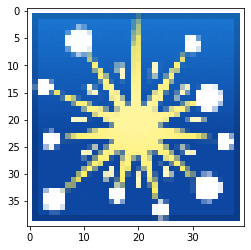

In [6]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [7]:
# Send target to device
target = target.to(device)

In [8]:
# Load the virus CA part
new_CA = NeuralCA(device=device)
new_CA.load("Pretrained_models/mask 70% persist v2.pt")
model = VirusCA(old_CA, new_CA, mutation_probability=0.7)

Successfully loaded model!


In [10]:
test_images = pool.sample(32)[0].to(device)
model.update_cell_mask(test_images[:32])

In [ ]:
pl.plot(test_70_90)
pl.plot(test_70_70)
pl.plot(test_70_50)
# pl.plot(test_90_70)
# pl.plot(test_90_50)
pl.plot(test_90_90)
# pl.plot(test_50_70)
# pl.plot(test_50_50)
pl.yscale("log")

In [ ]:
new_CA.load("Pretrained_models/virus 90% persist.pt")
model.mutation_probability = 0.9
model.update_cell_mask(test_images[:32])
test_90_90 = model.test_CA(criterion, test_images)

In [12]:
# Train the model
wandb.init()
wandb.watch(model, log_freq=64)

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=2e-3)
criterion = NCALoss(pad(target, TARGET_PADDING))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=120, scheduler=scheduler, kind="persist", skip_update=4, skip_damage=2)

epoch: 3
avg loss: 0.03763166740827728


In [ ]:
# Show losses
model.plot_losses()

In [ ]:
# Show a sample from the pool images
imshow(pool.sample(1)[0][0])

In [ ]:
wandb.finish()

In [ ]:
# Save the model and upload it to wandb
model.new_CA.save("Pretrained_models/mask 70% \regen no_padding.pt")

wandb.log({"state_dict": model.new_CA.state_dict()})
wandb.save("Pretrained_models/mask 70% \regen no_padding.pt")

In [ ]:
# Upload pool images to wandb
imgs = []

for i in range(12):
    img = np.asarray(pool.sample(1)[0][0].cpu().permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

In [ ]:
# Show the virus cell mask
pl.matshow(model.new_cells.cpu()[0,0])

In [ ]:
# Upload mask to wandb
wandb.log({"mask": wandb.Image(model.new_cells.cpu()[0,0])})

In [ ]:
# Make a switch video
_ , _ = switch_video(old_CA, model, fname="prova.mp4")

In [ ]:
# Upload the evolution video to wandb
wandb.log({"video": wandb.Video("prova.mp4", "video", fps=10, format="mp4")})

In [ ]:
# Evolve the CA for 200 iters and plot it
x, _ = pool.sample(1)
imshow(x[0])
x = x.to(device)
model.update_cell_mask(x)

with torch.no_grad():
    for i in range(200):
        x = model.forward(x)

imshow(x[0].cpu())

In [ ]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))

In [ ]:
wandb.finish()